## Workbook 2 - Training a Feed-Forward Neural Network using UrbanSound8K audio data 

In this workbook we load the features we extracted using librosa (see workbook 1).

We will use them to train a Feed-Forward Network, a simple deep neural net with a few hidden layers, and then predict the class of a set of previously unheard audio files.

You will need librosa, keras and tensorflow installed to run this code, and scikit-learn.

In [ ]:
#BASIC IMPORTS
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

#MOUNTING OUR DRIVE
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### This code below loads previously computed numpy features for each of the 10 folds
We'll use the first 8 for training, and keep one back for validation and one for testing.

In [ ]:
data_dir = "/content/drive/My Drive/ColabNotebooks/DSC 500 Seminar Project/My project/UrbanSound8K/audio"

# HERE is a a function which extracts all features and labels from each of the first 8 folds

def add_folds():
    subsequent_fold = False
    #only extracting the first 8 sets of numpy arrays
    for k in range(1,9):
        #deeloping the path id to extract features
        fold_name = 'fold' + str(k)
        print "\nAdding " + fold_name
        #feature file path
        feature_file = os.path.join(data_dir, fold_name + '_x.npy')
        #labels file path
        labels_file = os.path.join(data_dir, fold_name + '_y.npy')
        #loading in features
        loaded_features = np.load(feature_file)
        #loading in labels
        loaded_labels = np.load(labels_file)
        #Printing out the features for each files
        print "New Features: ", loaded_features.shape

        if subsequent_fold:
            features = np.concatenate((features, loaded_features))
            labels = np.concatenate((labels, loaded_labels))
        else:
            features = loaded_features
            labels = loaded_labels
            subsequent_fold = True
    
    return features, labels
#instantiating training sets
train_x, train_y = add_folds()

# use a fold for validation 
#creating paths for features and labels
valid_fold_name = 'fold9'
feature_file = os.path.join(data_dir, valid_fold_name + '_x.npy')
labels_file = os.path.join(data_dir, valid_fold_name + '_y.npy')
#loading in data for validation set
valid_x = np.load(feature_file)
valid_y = np.load(labels_file) 

# and a fold for testing
#creating paths for features and labels
test_fold_name = 'fold10'
feature_file = os.path.join(data_dir, test_fold_name + '_x.npy')
labels_file = os.path.join(data_dir, test_fold_name + '_y.npy')
#loading in data for validation set
test_x = np.load(feature_file)
test_y = np.load(labels_file)

#verify all data was loaded in correctly
print "\nTraining Set Features:", train_x.shape, "Labels:", train_y.shape
print "Validation Set Features:", valid_x.shape, "Labels:", valid_y.shape
print "Test Set Features:", test_x.shape, "Labels:", test_y.shape



Adding fold1
New Features:  (872, 193)

Adding fold2
New Features:  (888, 193)

Adding fold3
New Features:  (925, 193)

Adding fold4
New Features:  (990, 193)

Adding fold5
New Features:  (936, 193)

Adding fold6
New Features:  (823, 193)

Adding fold7
New Features:  (838, 193)

Adding fold8
New Features:  (815, 193)

Training Set Features: (7087, 193) Labels: (7087, 10)
Validation Set Features: (816, 193) Labels: (816, 10)
Test Set Features: (837, 193) Labels: (837, 10)


--------------------------------------------------------------------------------------------------------------------------

### Training Neural Network with Keras and TensorFlow

In [ ]:
#HERE we load in our imports required to use a feed forward neural network on our data
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [ ]:
#adding in our stolen verification function to make sure our path to our directory exists
def assure_path_exists(path):
    mydir = os.path.join(os.getcwd(), path)
    if not os.path.exists(mydir):
        os.makedirs(mydir)

# Creating/verifying our neural network dimensions
n_dim = train_x.shape[1]
n_classes = train_y.shape[1]
n_hidden_units_1 = n_dim
n_hidden_units_2 = 400 # approx n_dim * 2
n_hidden_units_3 = 200 # half of layer 2

checkpoint_dir = "model"
assure_path_exists(checkpoint_dir)

print "Features:", n_dim, "Classes:", n_classes

Features: 193 Classes: 10


## The following cell contains the code to create and train a feed-forward neural network with 3 hidden layers.

Notice how the training set loss decreases, whilst the accuracy increases, this shows the model is learning.

## But we don't want the model to simply memorise the training data and not have the capability to generalize examples it hasn't seen before. 

So a stopping function is used to evaluate a separate measure of loss against an unseen validation set, which allows training to be halted at the point when the model begins to lose its ability to generalise.

The neural network implemented below has 3 hidden layers, plus an output layer. A Dropout policy of 0.5 has been added. This means there's a 50% that a neuron's activation output will be ignored. This random throwing away of information helps prevent the network from learning simple dependencies, and promotes the creation adaptations between neurons of the hidden layers. 

Another parameter that affects performance is the batch size: the number of feature rows to be shown to the network before the backpropagation process updates the weights of the network. 


In [ ]:
#Setting our seeds
tf.random.set_seed(0)
np.random.seed(0)

#our model creation function
def create_model(activation_function='relu', init_type='normal', optimiser='Adamax', dropout_rate=0.5):
    # A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
    #we can add layers to the model using the method add()
    model = Sequential()

    # Dense implements the operation: output = activation(dot(input, kernel) + bias)
    # the activation function is passed as the activation argument inherent to Keras, 
    # kernel is a weights matrix created by the layer,
    # bias is a bias vector created by the layer.

    # layer 1
    model.add(Dense(n_hidden_units_1, input_dim=n_dim, init=init_type, activation=activation_function))
    # layer 2
    model.add(Dense(n_hidden_units_2, init=init_type, activation=activation_function))
    # The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
    model.add(Dropout(dropout_rate))
    # layer 3
    model.add(Dense(n_hidden_units_3, init=init_type, activation=activation_function))
    model.add(Dropout(dropout_rate))
    # output layer
    model.add(Dense(n_classes, init=init_type, activation='softmax'))
    
    # Once the model is created, you can config the model with losses and metrics with model.compile(), train the model with model.fit(), or use the model to do prediction with model.predict().
    model.compile(loss='categorical_crossentropy', optimizer=optimiser, metrics=['accuracy'])
    return model

# a stopping function to stop training before we excessively overfit to the training set
# This stops training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

#create model
model = create_model()


#WHEN USING KERAS THE OUTPUT OF FITTING THE MODEL IS A HISTORY OBJECT
#history attribute is a dictionary recording training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable).

history = model.fit(train_x, train_y, validation_data=(valid_x, valid_y), callbacks=[earlystop], nb_epoch=30, batch_size=24)


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(193, activation="relu", kernel_initializer="normal", input_dim=193)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", kernel_initializer="normal")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, activation="relu", kernel_initializer="normal")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="softmax", kernel_initializer="normal")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:43: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 7087 samples, validate on 816 samples
Epoch 1/30
7087/7087 [==============================] - 2s 237us/step - loss: 2.3759 - accuracy: 0.3090 - val_loss: 1.5749 - val_accuracy: 0.3873
Epoch 2/30
7087/7087 [==============================] - 1s 187us/step - loss: 1.6078 - accuracy: 0.4675 - val_loss: 1.4751 - val_accuracy: 0.4718
Epoch 3/30
7087/7087 [==============================] - 1s 185us/step - loss: 1.3646 - accuracy: 0.5455 - val_loss: 1.4005 - val_accuracy: 0.4804
Epoch 4/30
7087/7087 [==============================] - 1s 179us/step - loss: 1.2125 - accuracy: 0.6018 - val_loss: 1.3324 - val_accuracy: 0.5515
Epoch 5/30
7087/7087 [==============================] - 1s 181us/step - loss: 1.0741 - accuracy: 0.6511 - val_loss: 1.3622 - val_accuracy: 0.5515
Epoch 6/30
7087/7087 [==============================] - 1s 179us/step - loss: 0.9468 - accuracy: 0.6938 - val_loss: 1.4067 - val_accuracy: 0.5760
Epoch 7/30
7087/7087 [==============================] - 1s 180us/step - loss:

### Measuring Accuracy

In [ ]:
#Imports for measuring metrics

from sklearn import metrics 
from keras.utils import np_utils

# obtain the prediction probabilities
y_prob = model.predict_proba(test_x, verbose=0)
#y_pred = np_utils.probas_to_classes(y_prob)
y_pred = y_prob.argmax(axis=-1)
y_true = np.argmax(test_y, 1)
# receiver operating characteristic curve
roc = metrics.roc_auc_score(test_y, y_prob)
print "ROC:",  round(roc,2)

# evaluate the model
score, accuracy = model.evaluate(test_x, test_y, batch_size=32)
print("\nAccuracy = {:.2f}".format(accuracy))
#getting metrics
p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print "F-Score:", round(f,2)

ROC: 0.88
837/837 [==============================] - 0s 38us/step

Accuracy = 0.53
F-Score: 0.53


# Tuning Hyperparameters using GridSearch

ROC curves are typically used in binary classification, so to apply this measure to multi-class classification, it's first necessary to convert the predictions into boolean values, each representing positive or negative predictions for each possible class. This enables us to draw one ROC curve per class, or draw a composite ROC curve by using averaging.


NOTE: I didn't have much experience with coding ROC curves so I found a useful public ipython script which I used to aid my coding. (https://colab.research.google.com/github/rpi-techfundamentals/spring2019-materials/blob/master/05-intro-modeling/04-svm-roc.ipynb)

There were also some outside reading sources I used like the Website Towards Data Science (https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5)

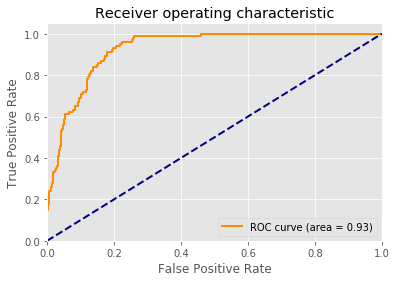

In [ ]:
#importing more metric gathering methods
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_y.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Showing Misclassification with a Confusion Matrix

We can visualise the accuracy using a confusion matrix, which shows which categories tend to be correctly classified, and which classes are misclassified. Compare, for example, the consistent classification of air conditioning, with the more equivocal results for children playing.

Confusion_matrix
           aircon   horn  child    dog  drill engine    gun hammer  siren  music
    aircon     42      0      1      0      0     25      0     20      0     12
      horn      3     24      0      1      2      0      0      1      0      2
     child      4      1     65      3      0      6      0      0      9     12
       dog      8      0     16     50      5      3      0      3      6      9
     drill      1      2      5      0     32     18      0     28      2     12
    engine      6      0     21      0      0     53      0      6      0      7
       gun      0      0      7      6      0      0     16      0      3      0
    hammer      0      0      2      0     23      0      0     71      0      0
     siren     20      0     11      0      0      5      0      3     43      1
     music      9      2     10      0     12      7      0      6      4     50


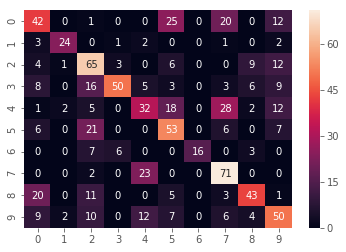

In [ ]:
#IMPORTING METRICS
from sklearn.metrics import confusion_matrix
#USING SEABORN FOR VISUAL PRUPOSES
import seaborn as sns

labels = ["aircon","horn","child","dog","drill","engine","gun","hammer","siren","music"]
print "Confusion_matrix"
cm = confusion_matrix(y_true, y_pred)

#USE Seaborn to make visually pleasing image
sns.heatmap(cm, annot=True)


#COMPUTATION HEAVY Confusion Matrix
def print_cm(cm, labels, hide_zeroes=False, hide_diagonal=False, hide_threshold=None):
    """pretty print for confusion matrixes"""
    columnwidth = max([len(x) for x in labels]+[5]) # 5 is value length
    empty_cell = " " * columnwidth
    # Print header
    print "    " + empty_cell,
    for label in labels: 
        print "%{0}s".format(columnwidth) % label,
    print
    # Print rows
    for i, label1 in enumerate(labels):
        print "    %{0}s".format(columnwidth) % label1,
        for j in range(len(labels)): 
            cell = "%{0}s".format(columnwidth) % cm[i, j]
            if hide_zeroes:
                cell = cell if float(cm[i, j]) != 0 else empty_cell
            if hide_diagonal:
                cell = cell if i != j else empty_cell
            if hide_threshold:
                cell = cell if cm[i, j] > hide_threshold else empty_cell
            print cell,
        print
    
print_cm(cm, labels)

### Refinement and Optimisation

Here we use Grid Search to successively train separate instances of a model with distinct values of key parameters, and then compare the resulting accuracy scores to identify which combination of parameters has produced the best results. 

Scikit-Learn provides GridSearch functionality that can be adapted for use with a neural network implemented using Keras, as described here: http://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/. 

In [ ]:
#Imports for GridSearch

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.constraints import maxnorm

#HYPTERPARAMTERS FOR TUNING

activations = ['relu', 'tanh', 'linear']
batch_sizes = [10, 20, 30, 40, 50, 60]
epochs = [10, 20, 30]
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
optimisers = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

model = KerasClassifier(build_fn=create_model, nb_epoch=5, batch_size=24, verbose=0)

# define the grid search parameters
# just using one here for illustration, but add activation_function=activations 
# or dropout_rate=dropout_rates to grid search on other parameters

# add more of the hyper-parameteres to the dictionary below to increase the GridSearch tuning

# Add statements like:
# activation_function=activations 
# dropout_rate=dropout_rates

param_grid = dict(optimiser=optimisers)

#call the GridSearch function
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)

print "Running GridSearch..."
grid_result = grid.fit(train_x, train_y)
print 
print
print "GridSearch complete"

# summarize results
print("Best Result: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Running GridSearch...


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(193, activation="relu", kernel_initializer="normal", input_dim=193)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", kernel_initializer="normal")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, activation="relu", kernel_initializer="normal")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="softmax", kern



GridSearch complete
Best: 0.471285 using {'optimiser': 'RMSprop'}
0.312121 (0.030269) with: {'optimiser': 'SGD'}
0.471285 (0.014615) with: {'optimiser': 'RMSprop'}
0.439396 (0.007548) with: {'optimiser': 'Adagrad'}
0.443347 (0.004437) with: {'optimiser': 'Adadelta'}
0.419924 (0.014891) with: {'optimiser': 'Adam'}
0.402004 (0.039751) with: {'optimiser': 'Adamax'}
0.443065 (0.020037) with: {'optimiser': 'Nadam'}


### Generating Predictions ###
Once we've trained a model, we can use the following process to pass an audio file into our model and generate predictions. Collectively, all the activations will sum to 1, meaning we can show what the network's best guess is. After all, as you can see from the results, the predictions are not perfect. 

In [ ]:
import librosa

sound_file_paths = ["aircon.wav", "carhorn.wav", "play.wav", "dogbark.wav", "drill.wav",
                    "engine.wav","gunshots.wav","jackhammer.wav","siren.wav","music.wav"]
sound_names = ["air conditioner","car horn","children playing","dog bark","drilling","engine idling",
               "gun shot","jackhammer","siren","street music"]
parent_dir = "/content/drive/My Drive/ColabNotebooks/DSC 500 Seminar Project/My project/samples/us8k/"


# just extract the features like we did in work  
def extract_features_only(filename):
    features = np.empty((0,193))
    X, sample_rate = librosa.load(filename)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
    features = np.vstack([features,ext_features])
    return features

# create predictions for each of the sound classes
print(sound_names)
for s in range(len(sound_names)):

    # load audio file and extract features
    predict_file = parent_dir + sound_file_paths[s]
    predict_x = extract_features_only(predict_file) 
    # generate prediction, passing in just a single row of features
    model.fit(train_x, train_y)
    predictions = model.predict(predict_x)
    #for i in range(len(predictions[0])):
    #    print sound_names[i], "=", round(predictions[0,i] * 100, 1)
    # get the indices of the top 2 predictions, invert into descending order
    print "\n----- ", sound_names[s], "-----"
    print("Top Prediction: " + str( sound_names[ int( predictions[0] ) ] ))


['air conditioner', 'car horn', 'children playing', 'dog bark', 'drilling', 'engine idling', 'gun shot', 'jackhammer', 'siren', 'street music']


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(193, activation="relu", kernel_initializer="normal", input_dim=193)`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(400, activation="relu", kernel_initializer="normal")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(200, activation="relu", kernel_initializer="normal")`
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(10, activation="softmax", kernel_initializer="normal")`



-----  air conditioner -----
Top Prediction: children playing

-----  car horn -----
Top Prediction: jackhammer

-----  children playing -----
Top Prediction: children playing

-----  dog bark -----
Top Prediction: dog bark

-----  drilling -----
Top Prediction: drilling

-----  engine idling -----
Top Prediction: jackhammer

-----  gun shot -----
Top Prediction: air conditioner

-----  jackhammer -----
Top Prediction: jackhammer

-----  siren -----
Top Prediction: siren

-----  street music -----
Top Prediction: street music


### Evaluating Convergence

There is also valuable information about learning performance in the history object. This can, for instance, reveal the speed of convergence over epochs.


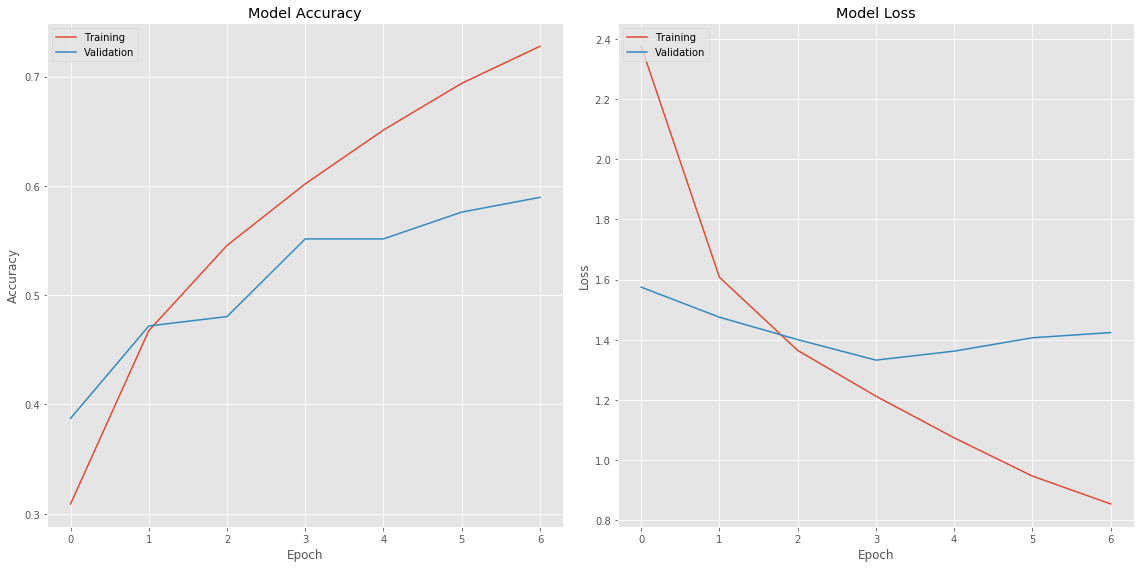

In [ ]:
# summarize history for accuracy

#initialize plot
fig = plt.figure(figsize=(16,8))
# summarise history for training and validation set accuracy
plt.subplot(1,2,1)
#plotting accuracies
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
#adding legends and titles
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

# summarize history for loss
#initialize plot
plt.subplot(1,2,2)
#plotting losses
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#adding legends and titles
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

plt.tight_layout()

plt.show()


The accuracy plot indicates whether the model could be trained further. It will also indicate if the model has over-learned the training dataset. If the model is overfitting the accuracy graph will show excellent performance on the training data, and poor performance on the test data.

Ideally, in the loss graph, we should see comparable performance in both the training and validation datasets. Should these parallel plots start to diverge, it might be a indication we should stop training earlier. For a more detailed explanation, see http://machinelearningmastery.com/display-deep-learning-model-training-history-in-kera

# Final Notes

As the feature extraction process relies on slicing the sound recordings into smaller, more manageable chunks, if we needed to predict the class of a longer recording, we might need to employ some kind of ensemble learning and then use a voting process to determine which source is declared the best guess. 

This voting approach could make use of the fact that the softmax activation function will return equivocal values if it has low confidence in its prediction. 

In such cases we could ignore weak predictions, ensuring only strong predictions contribute to the final voting decision. 